In [2]:
import os
import sys
# sys.path.append(os.path.abspath(os.path.dirname(__file__)))  # ensures current directory is included
sys.path.append("/home/s27mhusa_hpc/Master-Thesis/XMI_Files")
import spacy
from collections import Counter
import json


In [15]:
input_label_dir = "/home/s27mhusa_hpc/Master-Thesis/Dataset19SeptemberNoSoil/Test_BIO_labels_Broad_NoSoil_sentence"
input_token_dir = "/home/s27mhusa_hpc/Master-Thesis/Dataset19SeptemberNoSoil/Test_BIO_tokens_Broad_NoSoil_sentence"


all_labels = []

# Define crop-related labels to convert
crop_labels = [
    "cropSpecies", "cropVariety","Crops"
]
timestatement_labels = ["startTime", "endTime", "duration","Timestatement"]
location_labels = ["locationName","city","region","country","Location","latitude","longitude"]

# Define labels to remove (convert to O)
remove_labels = ["soilAvailableNitrogen", "soilBulkDensity", "soilDepth", 
    "soilOrganicCarbon", "soilPH", "soilReferenceGroup", "soilTexture","Soil"]

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)
    
    # labels = eval(content)  # list of BIO labels
    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        content = file.read()
    tokens = eval(content)

    i = 0
    while i < len(labels):
        label = labels[i]

        

        # Handle crop-related entities
        if any(label == f"B-{crop_label}" for crop_label in crop_labels):
            # Extract the crop label type (e.g., "cropSpecies" from "B-cropSpecies")
            crop_type = label[2:]  # Remove "B-" prefix
            entity_tokens = [i]
            j = i + 1
            while j < len(labels) and labels[j] == f"I-{crop_type}":
                entity_tokens.append(j)
                j += 1

            # Convert to generic Crop labels
            labels[i] = "B-Crop"
            for k in entity_tokens[1:]:
                labels[k] = "I-Crop"
            i = j
        elif any(label == f"B-{timestatement_label}" for timestatement_label in timestatement_labels):
            # Extract the time statement label type (e.g., "startTime" from "B-startTime")
            time_type = label[2:]  # Remove "B-" prefix
            entity_tokens = [i]
            j = i + 1
            while j < len(labels) and labels[j] == f"I-{time_type}":
                entity_tokens.append(j)
                j += 1

            # Convert to generic Time labels
            labels[i] = "B-TimeStatement"
            for k in entity_tokens[1:]:
                labels[k] = "I-TimeStatement"
            i = j
        elif any(label == f"B-{location_label}" for location_label in location_labels):
            # Extract the location label type (e.g., "city" from "B-city")
            location_type = label[2:]  # Remove "B-" prefix
            entity_tokens = [i]
            j = i + 1
            while j < len(labels) and labels[j] == f"I-{location_type}":
                entity_tokens.append(j)
                j += 1

            # Convert to generic Location labels
            labels[i] = "B-Location"
            for k in entity_tokens[1:]:
                labels[k] = "I-Location"
            i = j
        
        # Handle labels to remove (convert to O)
        elif any(label == f"B-{remove_label}" for remove_label in remove_labels):
            # Extract the label type to remove
            remove_type = label[2:]  # Remove "B-" prefix
            entity_tokens = [i]
            j = i + 1
            while j < len(labels) and labels[j] == f"I-{remove_type}":
                entity_tokens.append(j)
                j += 1
            
            # Convert all tokens of this entity to O
            for k in entity_tokens:
                labels[k] = "O"
            i = j
        else:
            i += 1

    # all_labels.extend(labels)
    with open(label_path, "w", encoding="utf-8") as file:
        file.write(str(labels))

In [16]:
from collections import Counter


all_labels = []
b_location_examples = []  # Store (label, token) pairs for B-locationName

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)
    
    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        token_content = file.read()
    tokens = eval(token_content)

    # Extend for overall count
    all_labels.extend(labels)

    # Collect B-locationName examples
    for label, token in zip(labels, tokens):
        if label == "I-cropSpecies":
            b_location_examples.append((label, token))
            print(filename)

# Count only B- labels and strip B-
b_counts = Counter(label[2:] for label in all_labels if label.startswith("B-"))

# Print label counts
print("📊 B-Label Counts:")
for label, count in b_counts.items():
    print(f"{label}: {count}")

# Print all B-locationName examples
print("\n📍 Tokens with B-Soil:")
for label, token in b_location_examples:
    print(f"{label}: {token}")


📊 B-Label Counts:
Crop: 89
TimeStatement: 112
Location: 59

📍 Tokens with B-Soil:


In [17]:
location_names = []
filenames = []

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)

    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        tokens = eval(file.read())

    i = 0
    while i < len(labels):
        if labels[i] == "B-Crops":
            location_tokens = [tokens[i]]
            i += 1
            while i < len(labels) and labels[i] == "I-Crops":
                location_tokens.append(tokens[i])
                i += 1
            location_names.append(" ".join(location_tokens))
            filenames.append(filename)
        else:
            i += 1

# Print full location names
print("\n📍 Full Location Names:")
for loc in location_names:
    print(loc)
print("\n📍 Full filenames Names:")
for filename in filenames:
    print(filename)


📍 Full Location Names:

📍 Full filenames Names:


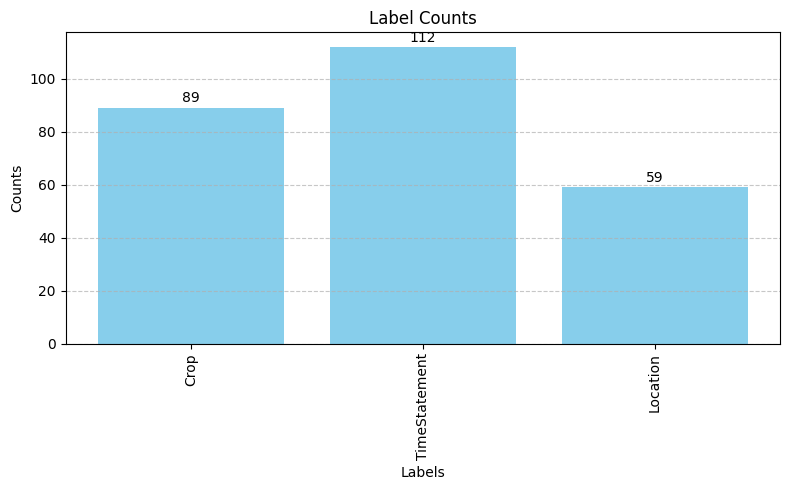

In [18]:
import matplotlib.pyplot as plt
# Extract labels and counts
labels = list(b_counts.keys())
counts = list(b_counts.values())

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color='skyblue')
plt.title("Label Counts")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=90)

# Add count labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()